# Experiment 2


<br><br>

### Exp2

- After replicating one of the [Anthropic research outcome (Elhage et al., 2022)](https://transformer-circuits.pub/2022/toy_model/index.html) (see the left square box in the diagram below), the next step is to replicate the remaining twos to examine if neural nets with only 2 dims can represent more than two features like the remaining square boxes below.
- Because using real noisy image datasets of the MNIST hand-written digit images in this experiment (instead of hypothetically synthetic features used in the Anthropic work), I expect that results will be messy, meaning that achieving either of the two remaining features representation patterns or any other multiple features represenations would be expected when sparsity level is set to highly larger than 0.0 (e.g. 0.99-0.999).
- Different from the previous experiment, I also implemented sparsity penalty with the [kl divergence method](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).
- Additionally, I set a high sparsity level to the hidden layer (i.e. 49 dim) of the linear model so that neural information sending into the sparse autoencoder (SAE) model is already sparse.

<br>

![alt text](../img/exp1_diagram1.png "Diagram1")


<br><br>

### Exp2.0. Prepare packages

<br><br>


In [1]:
### import packages 

# ml/nn
import torch
import torch.nn as nn  # all neural network modules
import torch.nn.functional as F  # Functions with no parameters -> activation functions
import torch.optim as optim  # optimization algo

from torch.utils.data import DataLoader, Dataset # easier dataset management, helps create mini batches
from torch.utils.data import random_split # set train-test ratio

# import torchvision
import torchvision.datasets as datasets  # standard datasets
import torchvision.transforms as transforms # this for convert dataset to tensor
from torchvision.utils import make_grid # this for visualization

# stats/ml #1
import numpy as np
import matplotlib.pyplot as plt

# stats/ml #2
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

import random


<br><br>

### Exp2.1. Run first exp

<br><br>


In [2]:
### set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
### define original functions

def norm_point(x, y):
    # Calculate the length of the vector
    length = np.sqrt(x**2 + y**2)
    
    # Check where length is 0
    zero_mask = (length == 0)  # Boolean mask for elements where length is 0

    # Initialize normalized coordinates
    x_norm = np.zeros_like(x)
    y_norm = np.zeros_like(y)
    
    # Perform normalization only where length != 0
    x_norm[~zero_mask] = x[~zero_mask] / length[~zero_mask]
    y_norm[~zero_mask] = y[~zero_mask] / length[~zero_mask]
    
    # For dimensions where length == 0, retain the original values
    x_norm[zero_mask] = x[zero_mask]
    y_norm[zero_mask] = y[zero_mask]

    return x_norm, y_norm

In [4]:
### Define all parameters

# later these will be inserted at the beginning as args

# fixed
batch_size = 64
input_size = 784
num_classes = 10

# variable
hidden_size = 49  # for lin model
hidden_size2 = 2 # for sae hidden dim
lr1 = 0.001
lr2 = 0.0001

# when sparsity lv is close to 0, feature is dense
sparsity_lv = 0.999 # interestingly, sparsity level should be as high as 0.999 or higher to get multiple feature representations
sparsity_impact = 1e-4 
eps = 1e-8 # epsilon

In [5]:
### define datasets

# load dataset
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
### implement single layer linear (MLP) model, classic autoencoder model, sparse autoencoder model

# linear (MLP) model
class lin_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, 
                 sparsity_lambda=1e-4, sparsity_target=0.8, epsilon=1e-8
                ):  
        super(lin_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input: 28x28=784, hidden: 7x7=49
        self.fc2 = nn.Linear(hidden_size, num_classes) # hidden: 49, num_classes: 10

        self.sparsity_lambda = sparsity_lambda # sparsity penalty impact
        self.sparsity_target = sparsity_target # target sparsity distribution
        self.epsilon = epsilon

        # paper said, initialization use the Kaiming Uniform initialization
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)

    def forward(self, x):
        x = self.fc1(x) # 784->49
        x = torch.tanh(x) # range within [-1:1]
        x_h = F.relu(x) # add non-linearity
        x = self.fc2(x_h) # 49->10
        return x, x_h
        
    # paper said used sum, but I will explore with kl divergence
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = self.epsilon
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1 - epsilon)
        kl_divergence = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        sparsity_penalty = torch.sum(kl_divergence)
        return self.sparsity_lambda * sparsity_penalty

    # this forces the linear model neural activations to be sparse before sending them to SAE model
    def loss_function(self, x_hat, x, encoded):
        crossE_loss = F.cross_entropy(x_hat, x)
        sparsity_loss = self.sparsity_penalty(encoded)
        return crossE_loss + sparsity_loss

# sparse autoencoder (SAE)
class sae_model(nn.Module):
    def __init__(self, encoder, decoder, 
                 sparsity_lambda=1e-4, sparsity_target=0.8, epsilon=1e-8
                ):
        super(sae_model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sparsity_lambda = sparsity_lambda # sparsity penalty impact
        self.sparsity_target = sparsity_target # target sparsity distribution
        self.epsilon = epsilon

        # paper said, initialization use the Kaiming Uniform initialization
        nn.init.kaiming_uniform_(self.encoder.fc_enc.weight)
        nn.init.constant_(self.encoder.fc_enc.bias, 0)
        
        # paper said, initialization use the Kaiming Uniform initialization
        nn.init.kaiming_uniform_(self.decoder.fc_dec.weight)
        nn.init.constant_(self.decoder.fc_dec.bias, 0)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    # paper said used sum, but I will explore with kl divergence
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = self.epsilon
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1 - epsilon)
        kl_divergence = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        sparsity_penalty = torch.sum(kl_divergence)
        return self.sparsity_lambda * sparsity_penalty
    
    def loss_function(self, x_hat, x, encoded):
        mse_loss = F.mse_loss(x_hat, x)
        sparsity_loss = self.sparsity_penalty(encoded)
        return mse_loss + sparsity_loss

# encoder net/layer
class encoderNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(encoderNN, self).__init__()
        self.fc_enc = nn.Linear(input_size, hidden_size)
    def forward(self, x):
        x = self.fc_enc(x) # 49->2
        x = torch.tanh(x) # range [-1:1] as similar operations as previous exp
        # x = F.relu(x)
        return x

# decoder net/layer
class decoderNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(decoderNN, self).__init__()
        self.fc_dec = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc_dec(x) # 2 -> orig(49) dim
        x = torch.tanh(x) # same as the above
        x = F.relu(x)
        return x

# classic autoencoder
class ae_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ae_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input: 49, target_dim: 2, for visualising superposition in 2d
        self.fc2 = nn.Linear(hidden_size, input_size) # input: 2, target_dim: 49
    def forward(self, x):
        x = self.fc1(x) # 49->2
        x_2d = torch.tanh(x) # range within [-1:1]
        x = self.fc2(x_2d) # 2->49
        x = torch.tanh(x) # range within [-1:1]
        x = F.relu(x) # simulate lin_model's process
        return x, x_2d


In [7]:
### initialize model, loss, optimizer

m1 = lin_model(
    input_size=input_size,
    hidden_size=hidden_size, # 49
    num_classes=num_classes, # 10
    sparsity_lambda=sparsity_impact, 
    sparsity_target=sparsity_lv, 
    epsilon=eps
).to(device)

enc_m = encoderNN(input_size=hidden_size, hidden_size=hidden_size2)
dec_m = decoderNN(hidden_size=hidden_size2, output_size=hidden_size)

m2 = sae_model(
    encoder=enc_m, 
    decoder=dec_m, 
    sparsity_lambda=sparsity_impact, 
    sparsity_target=sparsity_lv, 
    epsilon=eps
).to(device)

# Loss and Optimizer
# criterion1 = nn.CrossEntropyLoss()
# criterion2 = nn.MSELoss()
opt1 = optim.Adam(m1.parameters(), lr=lr1) 
opt2 = optim.Adam(m2.parameters(), lr=lr2) 


In [8]:
### train and validaiton

###
### phase 1: prepare trained weights with larger dim
###

num_epochs1 = 10

# training lin model
for epoch in range(num_epochs1):

    # Training
    for batch_idx, (data, targets) in enumerate(train_loader):

        # reshape [batch, 1, 28,28] to [batch, 28*28]
        data = data.reshape(-1, 28*28)

        # Step 1: Forward pass through model1
        out1, h1 = m1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
        
        # Step 4: Compute loss1 and update model1
        loss1 = m1.loss_function(out1, targets, h1)
        # loss1 = criterion1(out1, targets)
        opt1.zero_grad()
        loss1.backward()
        opt1.step()

    num_correct = 0
    num_samples = 0
    
    # Validation
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.reshape(-1, 28*28)
            out1, _ = m1(data)
            _, predictions = out1.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        accuracy = num_correct/num_samples
    
    print(f"Epoch [{epoch+1}/{num_epochs1}], loss1: {loss1.item():.4f}, accuracy: {accuracy.item():.4f}")

Epoch [1/10], loss1: 0.1754, accuracy: 0.9266
Epoch [2/10], loss1: 0.1520, accuracy: 0.9399
Epoch [3/10], loss1: 0.0670, accuracy: 0.9480
Epoch [4/10], loss1: 0.0782, accuracy: 0.9524
Epoch [5/10], loss1: 0.1857, accuracy: 0.9556
Epoch [6/10], loss1: 0.0627, accuracy: 0.9570
Epoch [7/10], loss1: 0.0613, accuracy: 0.9589
Epoch [8/10], loss1: 0.0357, accuracy: 0.9598
Epoch [9/10], loss1: 0.0432, accuracy: 0.9605
Epoch [10/10], loss1: 0.0546, accuracy: 0.9609


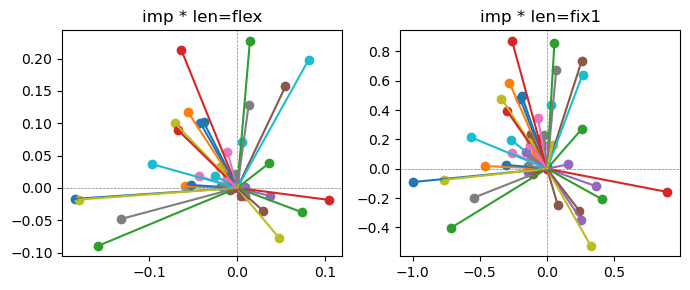

Epoch [1/20], loss2: 0.2968


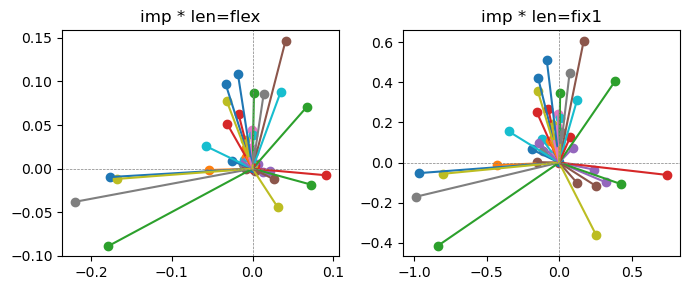

Epoch [2/20], loss2: 0.2634


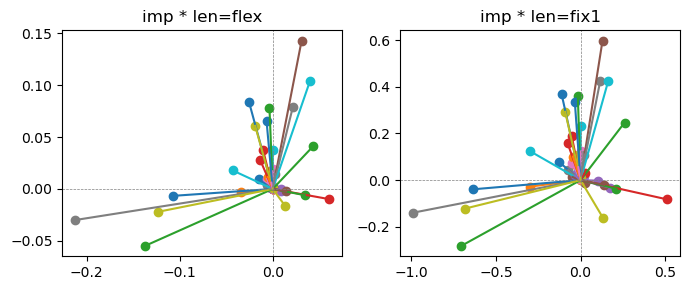

Epoch [3/20], loss2: 0.2642


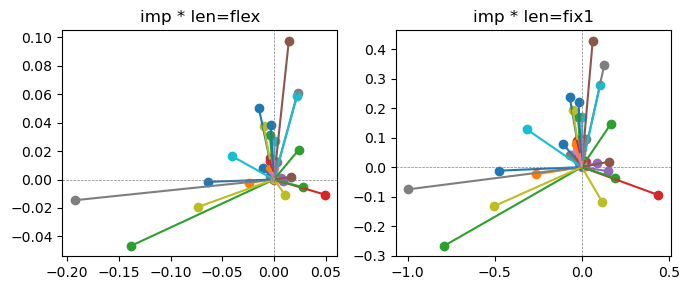

Epoch [4/20], loss2: 0.2246


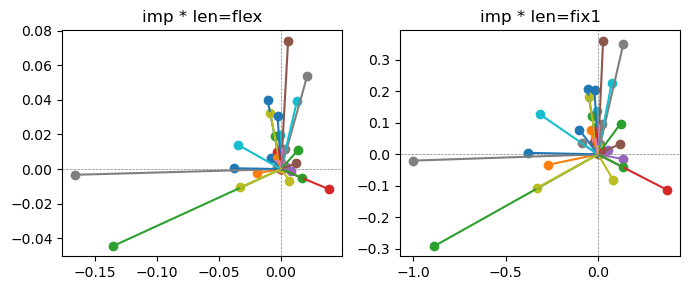

Epoch [5/20], loss2: 0.2011


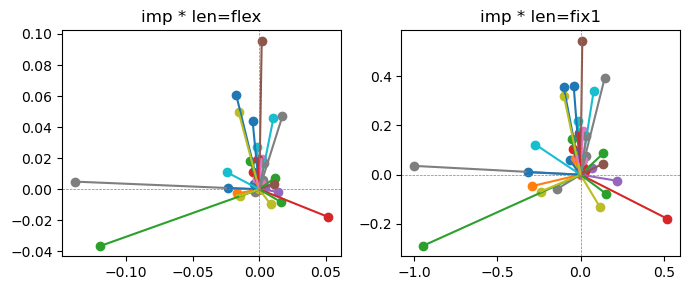

Epoch [6/20], loss2: 0.1949


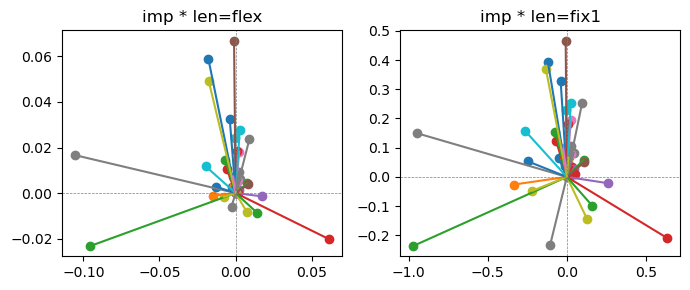

Epoch [7/20], loss2: 0.1867


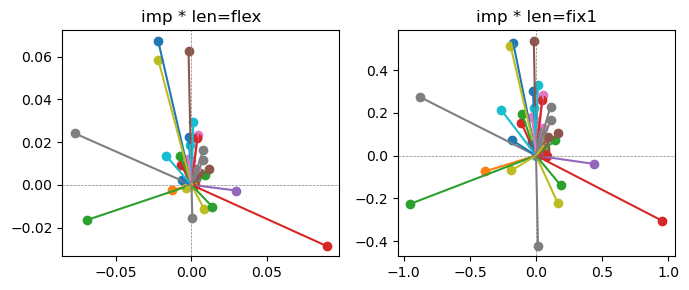

Epoch [8/20], loss2: 0.1851


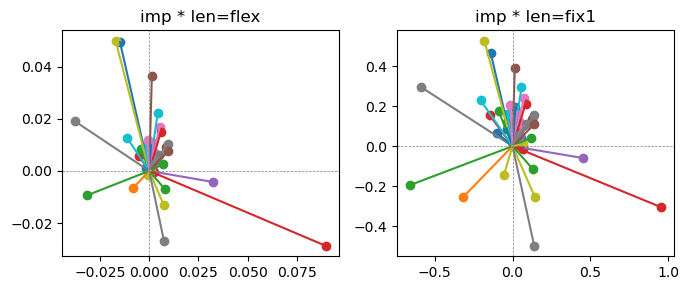

Epoch [9/20], loss2: 0.1882


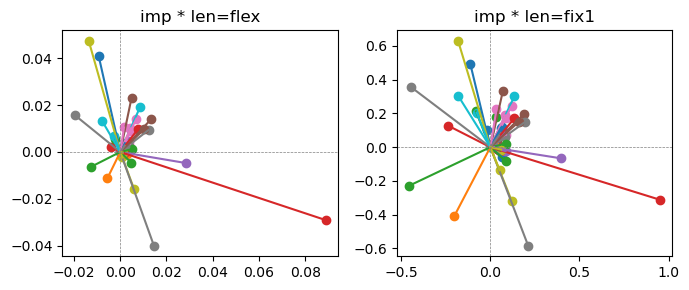

Epoch [10/20], loss2: 0.1801


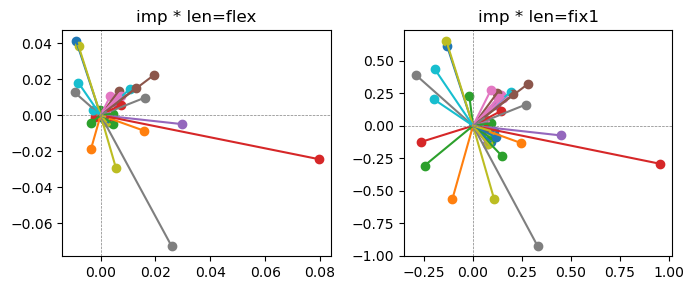

Epoch [11/20], loss2: 0.1713


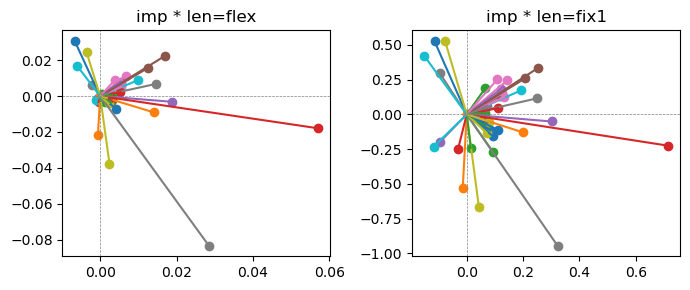

Epoch [12/20], loss2: 0.1683


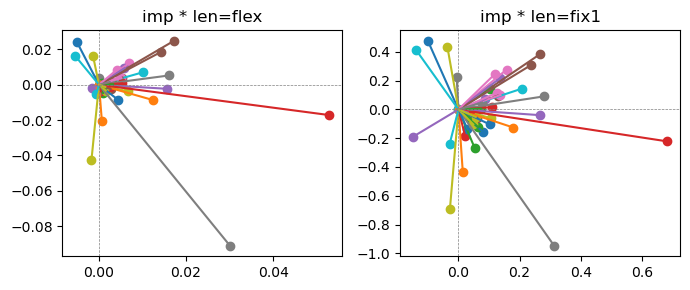

Epoch [13/20], loss2: 0.1672


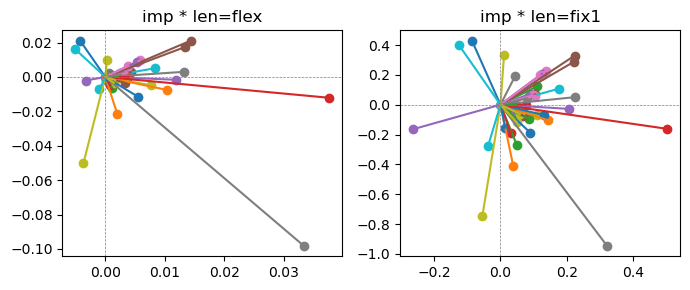

Epoch [14/20], loss2: 0.1633


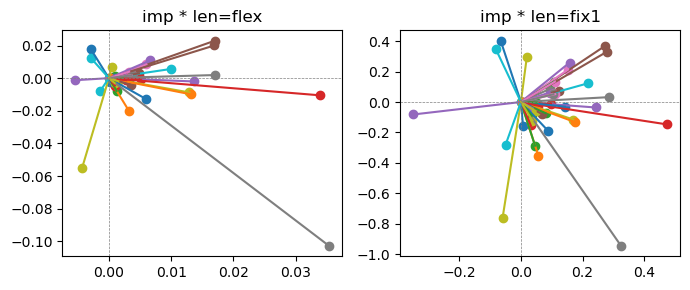

Epoch [15/20], loss2: 0.1595


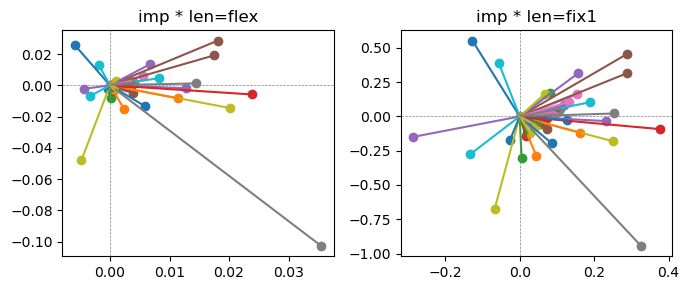

Epoch [16/20], loss2: 0.1436


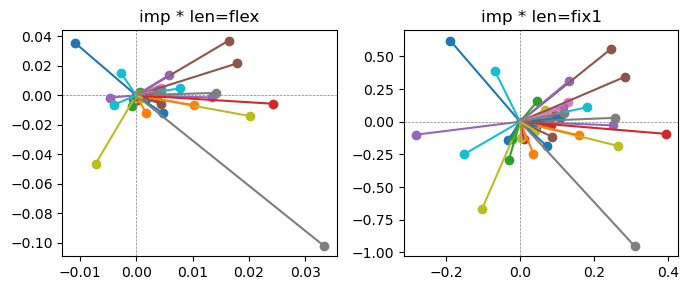

Epoch [17/20], loss2: 0.1606


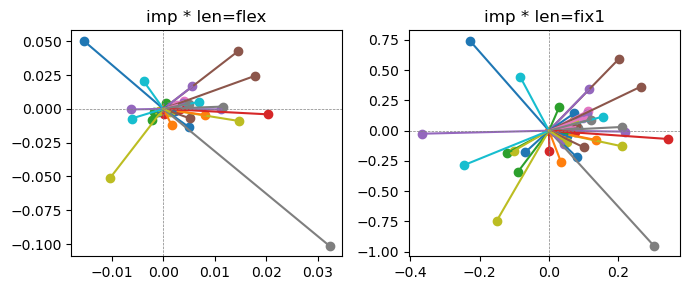

Epoch [18/20], loss2: 0.1410


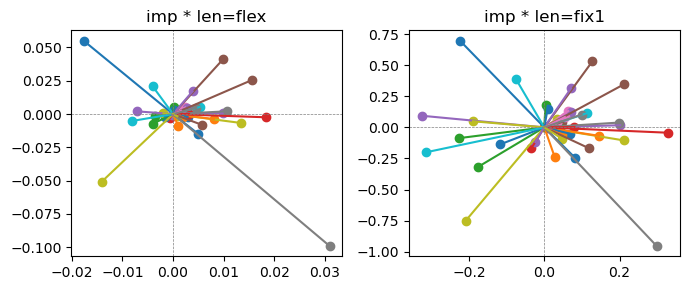

Epoch [19/20], loss2: 0.1432


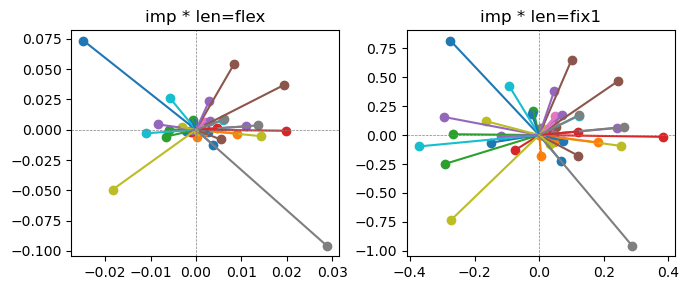

Epoch [20/20], loss2: 0.1392


In [9]:
###
### phase 2: train AE model weights with 2 dim
###

num_epochs2 = 20

# training ae model and visualize results
for epoch in range(num_epochs2):

    # Training autoencoder model
    for batch_idx, (data, targets) in enumerate(train_loader):

        # reshape [batch, 1, 28,28] to [batch, 28*28]
        data = data.reshape(-1, 28*28)

        with torch.no_grad():
            _, h1 = m1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
            h1_clone = h1.detach()
        
        out2, encoded = m2(h1_clone)  # 49 -> 2 -> 49

        loss2 = m2.loss_function(out2, h1_clone, encoded)
        # loss2 = criterion2(out2, h1_clone)
        opt2.zero_grad()
        loss2.backward()
        opt2.step()

    # visualization
    with torch.no_grad():

        # Collecting data # lin model
        for batch_idx, (data, targets) in enumerate(train_loader):

            data = data.reshape(-1, 28*28)
            _, h1 = m1(data)
            
            if batch_idx == 0:
                target_h1 = h1
            else:
                target_h1 = torch.vstack((target_h1,h1))

        # Collecting data # ae model
        reconstruct_target_h1, h2_2d = m2(target_h1)
        
        # Collecting data # original loss
        target_loss2_orig = m2.loss_function(reconstruct_target_h1, target_h1, h2_2d)
        # target_loss2_orig = criterion2(reconstruct_target_h1, target_h1)

        # Importance and xy2d coord calculation        
        batch_size, large_model_dim = target_h1.shape
        importance = []
        target_dim_2d = []

        for one_dim in range(large_model_dim):

            # importance
            h1_perturb = target_h1.clone()
            h1_perturb[:,one_dim] = 0.0
            reconstruct_h1_perturb, encoded_perturb = m2(h1_perturb)
            loss2_perturb = m2.loss_function(reconstruct_h1_perturb, target_h1, encoded_perturb)
            # loss2_perturb = criterion2(reconstruct_h1_perturb, target_h1)
            importance.append(loss2_perturb - target_loss2_orig)

            # xy_2d
            target_h1_one_dim = torch.zeros_like(target_h1, dtype=torch.float) # batch, larger dim
            target_h1_one_dim[:,one_dim] = target_h1[:,one_dim]
            _, target_h1_2d = m2(target_h1_one_dim)
            target_dim_2d.append(target_h1_2d.mean(axis=0))
        
        target_dim_2d = np.array(target_dim_2d)
        
        # calculate importance according to contribution to MSE loss
        importance = np.array([imp/sum(importance) for imp in importance])
        # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
        importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range

        # compute xy_coordinates

        # use raw xy2d with unrestricted magnitude vector as it is
        xy_coord = importance_norm[:, np.newaxis] * target_dim_2d # because calculate [large_dim,]*[large_dim,xy_coord]
        # xy_coord = xy_coord/np.abs(xy_coord).max() # adjust max magnitude to -1.0 to 1.0
        x_coord = xy_coord[:,0]
        y_coord = xy_coord[:,1]

        # set a magnitude of xy2d with 1
        x_coord_norm, y_coord_norm = norm_point(target_dim_2d[:,0], target_dim_2d[:,1])
        x_coord_norm = x_coord_norm * importance_norm
        y_coord_norm = y_coord_norm * importance_norm

        # graph visualization
        fig, ax = plt.subplots(1,2, figsize=(7,3))
        for i in range(len(x_coord)):
            ax[0].scatter(x_coord[i], y_coord[i])
            ax[0].plot([0,x_coord[i]],[0,y_coord[i]])
            ax[1].scatter(x_coord_norm[i], y_coord_norm[i])
            ax[1].plot([0,x_coord_norm[i]],[0,y_coord_norm[i]])

        ax[0].title.set_text(f"imp * len=flex")
        ax[0].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[0].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[1].title.set_text(f"imp * len=fix1")
        ax[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax[1].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    print(f"Epoch [{epoch+1}/{num_epochs2}], loss2: {loss2.item():.4f}")


<br><br>

### Exp2.2. Result 1

- m1 = the one layer linear model outputing a hidden layer dim (49 dim) while training the 10 class hand-wrriten digit images (28x28 = 784 dim).
- m2 = the SAE model training the larger hidden layer dim (49 dim) representing each feature in a smaller hidden layer dim (2 dim).
- in this experiment, sparsity level was added, especially in this case setting highly sparsity level (ie 0.999) to get ideal results.
- the left boxes are graphs representing each of 49 features computed by m2 output (2 dim, xy coordinates) multiplying with its importance.
- the right boxes are graphs representing each of 49 features computed by a vector of m2 output (2 dim, xy coordinates) with fixed magnitude=1 multiplying with its importance.
- 49 features are not aggregated into 2 features over 20 epochs training.
- This study demonstrated that setting a highly sparsity level helped to form multiple feature representations.

<br>



<br>

### Exp2.3. Run second exp

The second exp will test to replicate another [Anthropic research outcome (Elhage et al., 2022)](https://transformer-circuits.pub/2022/toy_model/index.html) (see the 2nd-7th columns of the **ReLU Output Model** in the diagram below). Namely, testing if multiple features (more than 2 dim) are clearly represented in the toy model, when sparsity is set (sparsity=0.999).

Here, 
- W in h = W * x is an AE transformation from x(49dim) to h(2dim).
- b is a bias in h = W * x + b.
- W<sup>T</sup> in x' = ReLU(W<sup>T</sup> * W * x + b) is a reconstruction from h(2dim) to x'(49 dim)
- W<sup>T</sup> * W represents cosine similarity matrix between features (48x48 matrix).
- ||$W_i$|| tests if each feature is clearly represented.
- $\sum_{j} (\hat{x}_i*x_j)^2$ calculates similarity of a target feature, $\hat{x}_i$, with the remaining features.

<br><br>


![alt text](../img/exp1_diagram2.png "Diagram2")

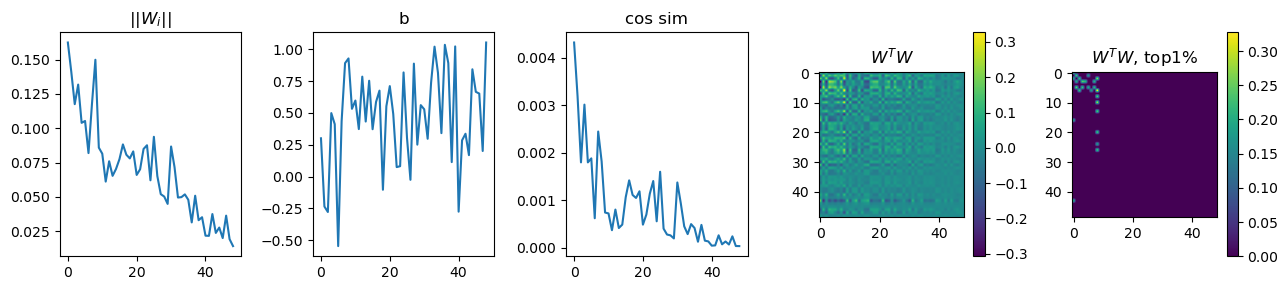

In [10]:
### demonstrate wT*w, W-norm, cos sim distance

with torch.no_grad():
    w1 = m2.encoder.fc_enc.weight.detach().numpy()
    w2 = m2.decoder.fc_dec.weight.detach().numpy()
    b1 = m2.encoder.fc_enc.bias.detach().numpy()
    b2 = m2.decoder.fc_dec.bias.detach().numpy()
    
    # Sort the columns of 'a' based on importance
    sorted_indices = np.argsort(importance_norm)[::-1] # Get indices that would sort the importance array
    w1_sorted = w1[:, sorted_indices] # Reorder the columns of 'a' based on sorted indices
    w2_sorted = w2[sorted_indices, :] # Reorder the columns of 'a' based on sorted indices
    b2_sorted = b2[sorted_indices][::-1] # Reorder the columns of 'a' based on sorted indices, and transpose as wT

    w1_sorted_t = w1_sorted.T
    mask_range = np.array(range(len(w1_sorted_t)))
    w1_cos_sim = []
    w2_cos_sim = []

    for i in range(len(w1_sorted_t)):
        w1_sorted_t_target = w1_sorted_t[i]
        idx_mask = (mask_range == i)
        w1_sorted_t_ref = w1_sorted_t[~idx_mask]
        cos_sim1 = ((w1_sorted_t_target @ w1_sorted_t_ref.T)**2).sum()
        w1_cos_sim.append(cos_sim1)

        w2_sorted_target = w2_sorted[i]
        idx_mask = (mask_range == i)
        w2_sorted_ref = w2_sorted[~idx_mask]
        cos_sim2 = ((w2_sorted_ref @ w2_sorted_target)**2).sum()
        w2_cos_sim.append(cos_sim2)

    w1_cos_dis = np.array(w1_cos_sim)
    w2_cos_dis = np.array(w2_cos_sim)

    x = w1_sorted.T[:,0]
    y = w1_sorted.T[:,1]
    w_norm = np.sqrt(x**2 + y**2)

    wtw = (w2_sorted @ w1_sorted)
    # wtw = (w_sorted.T @ w_sorted)

    wtw_clone = wtw.copy()
    thres = np.percentile(wtw_clone, [99])
    wtw_clone[wtw_clone<thres] = 0.0

    fig, ax = plt.subplots(1,5, figsize=((13,3)))

    ax[0].plot(w_norm) # ||Wi||
    ax[1].plot(b2_sorted) # b    
    ax[2].plot(w1_cos_dis) # cos sim
    pos1 = ax[3].imshow(wtw)
    pos2 = ax[4].imshow(wtw_clone)

    ax[0].title.set_text(f"||$W_{'i'}$||")
    ax[1].title.set_text(f"b")
    ax[2].title.set_text(f"cos sim")
    ax[3].title.set_text(f"$W^TW$")
    ax[4].title.set_text(f"$W^TW$, top1%")

    fig.colorbar(pos1)
    fig.colorbar(pos2)

    plt.tight_layout()
    # plt.savefig("img.png")
    plt.show()

<br>

### Exp2.4. Result 2

- When feature representations are more than two, the W<sup>T</sup>W outcome also showed higher correlations spreadding out across features, whereas highly correlated features are still the ones with higly important features.
- Too bad, I did not set up model hyperparameters properly such that outputs of ||Wi||, b, and cos sim are slightly diferent in unit (see y-axis of each) than the Anthropic's outcome.

<br><br>

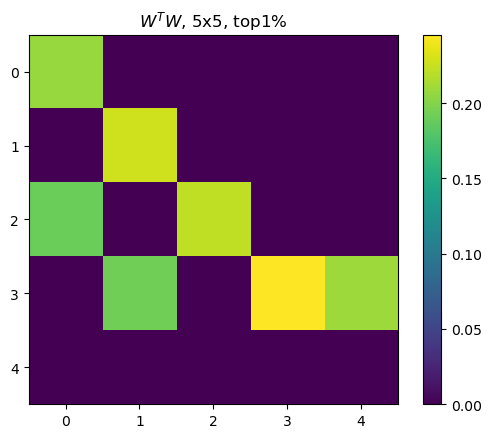

In [11]:
pos = plt.imshow(wtw_clone[:5,:5])
plt.colorbar(pos)
plt.title(f"$W^TW$, 5x5, top1%")
plt.show()